# Histopathologic Cancer Detection

In [1]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


TensorFlow Version: 2.1.0
Default GPU Device: /device:GPU:0
Num GPUs Available:  1


# Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd 
from tqdm import tqdm

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split

from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

#VGG16
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

from cfg import Config
import pickle

#from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.nasnet import NASNetMobile
from keras.applications.xception import Xception
from keras.utils.vis_utils import plot_model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D
from keras.models import Model
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam

Using TensorFlow backend.


## Data Directory

In [5]:
input_dir = '/Users/ACER/Desktop/hpc_dataset/'
cropped_train_dir = input_dir + 'cropped_train/'
cropped_val_dir = input_dir + 'cropped_val/'

## Data Loading and Augmentation

In [6]:
# Data augmentation
training_data_generator = ImageDataGenerator(rescale=1./255,
                                             horizontal_flip=True,
                                             vertical_flip=True,
                                             rotation_range=180,
                                             zoom_range=0.2, 
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             shear_range=0.1,
                                             channel_shift_range=0.2)

In [7]:
# Data augmentation
val_data_generator = ImageDataGenerator(rescale=1./255)

In [8]:
# Data generation
training_generator = training_data_generator.flow_from_directory(cropped_train_dir,
                                                                 target_size=(48,48),
                                                                 batch_size=32,
                                                                 class_mode='binary')

Found 176020 images belonging to 2 classes.


In [9]:
validation_generator = val_data_generator.flow_from_directory(cropped_val_dir,
                                                              target_size=(48,48),
                                                              batch_size=32,
                                                              class_mode='binary')

Found 44005 images belonging to 2 classes.


## Model Building and Training

In [3]:
## Current most promising. No augmentation. VGG 16 all-do(0.5)-dense512-do(0.5)-dense1. Learning rate:10-4

def VGG16_model():
    base_model = VGG16(include_top=False,
                       input_shape = (48,48,3),
                       weights = 'imagenet')

    #for layer in base_model.layers[:-10]:
    #    layer.trainable = False
    
    #for layer in base_model.layers:
    #    print(layer,layer.trainable)
    
    model = Sequential()
    model.add(base_model)
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    #model.layers[0].trainable=False
    model.summary()
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr=0.0001, decay=0.00001),
                  metrics=['acc'] )
    return model

In [4]:
model = VGG16_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 14,715,201
Trainable params: 14,715,201
Non-trainable params: 0
_________________________________________________________________


In [10]:
model_file = "models/model_v19.h5"

checkpoint = ModelCheckpoint(model_file, monitor='val_acc',
                             verbose=1, save_best_only=True,
                             mode='max', save_weights_only=False, 
                             period=1)

earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001,
                          patience=10, verbose=1, 
                          mode='auto')

history = model.fit_generator(training_generator,
                              steps_per_epoch=len(training_generator), 
                              validation_data=validation_generator,
                              validation_steps=len(validation_generator),
                              epochs=10,
                              verbose=1,
                              callbacks=[checkpoint])

# Save the best model
model.save(model_file)

Epoch 1/10
5501/5501 [==============================] - 1808s 329ms/step - loss: 0.4107 - acc: 0.8219 - val_loss: 1.2680 - val_acc: 0.8611

Epoch 00001: val_acc improved from -inf to 0.86108, saving model to models/model_v19.h5
Epoch 2/10
5501/5501 [==============================] - 1744s 317ms/step - loss: 0.3292 - acc: 0.8622 - val_loss: 0.9425 - val_acc: 0.8878

Epoch 00002: val_acc improved from 0.86108 to 0.88781, saving model to models/model_v19.h5
Epoch 3/10
5501/5501 [==============================] - 1707s 310ms/step - loss: 0.3046 - acc: 0.8740 - val_loss: 0.3364 - val_acc: 0.8926

Epoch 00003: val_acc improved from 0.88781 to 0.89258, saving model to models/model_v19.h5
Epoch 4/10
5501/5501 [==============================] - 1745s 317ms/step - loss: 0.2910 - acc: 0.8803 - val_loss: 0.0437 - val_acc: 0.8749

Epoch 00004: val_acc did not improve from 0.89258
Epoch 5/10
5501/5501 [==============================] - 1708s 311ms/step - loss: 0.2770 - acc: 0.8869 - val_loss: 0.2472

## Training Plot

Text(0, 0.5, 'loss')

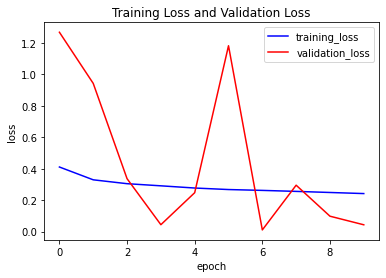

In [18]:
plt.plot(history.history['loss'], color='blue', label="training_loss")
plt.plot(history.history['val_loss'], color='red', label="validation_loss")
plt.legend(loc='best')
plt.title('Training Loss and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

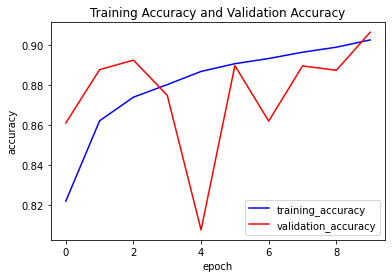

In [19]:
plt.plot(history.history['acc'], color='blue', label="training_accuracy")
plt.plot(history.history['val_acc'], color='red',label="validation_accuracy")
plt.legend(loc='best')
plt.title('Training Accuracy and Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

1376/1376 [==============================] - 111s 81ms/step


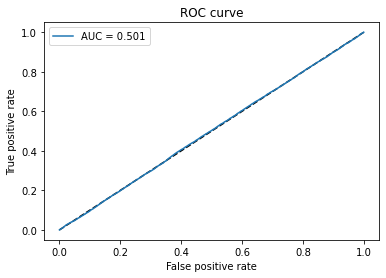

In [13]:
# ROC testing plot
predictions = model.predict_generator(validation_generator, steps=len(validation_generator), verbose=1)
false_positive_rate, true_positive_rate, threshold = roc_curve(validation_generator.classes, predictions)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

## Model Testing

In [ ]:
from keras.models import load_model
model = load_model(model_file)

from skimage.io import imread
from glob import glob
from tqdm import tqdm

testing_batch_size = 1000

testing_files = glob(os.path.join('/Users/ACER/Desktop/hpc_dataset/cropped_test/','*.tif'))
submission = pd.DataFrame()
for index in tqdm(range(0, len(testing_files), testing_batch_size)):
    data_frame = pd.DataFrame({'path': testing_files[index:index+testing_batch_size]})
    data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[5].split(".")[0])
    data_frame['image'] = data_frame['path'].map(imread)
    images = np.stack(data_frame.image, axis=0)
    predicted_labels = [model.predict(np.expand_dims(image/255.0, axis=0))[0][0] for image in images]
    predictions = np.array(predicted_labels)
    data_frame['label'] = predictions
    submission = pd.concat([submission, data_frame[["id", "label"]]])
submission.to_csv("submission_ar_20.csv", index=False, header=True)